### Prisioner's Dilemma

- There are two agents that interact in repeated prisioner's dilemma. 
- Actions are: defect (D/0) or confess (C/1).
- Rewards for agents are 

    - (3,3) for (D,D) 
    - (0,5) for (D,C) 
    - (5,0) for (C,D) 
    - (1,1) for (C,C)

- There is just one state that does not change. State does not play a role here, it is just a placeholder. 
- There is no "discounting". Agents only value current profits - they do not seek to maximize discounted sum. 
- The Nash Eqbm is (C,C) where both agents confess and end up getting a bad outcome for themselves. 
- This is because D is a strictly dominanted strategy, regardless of what the other plays.

### Import Packages

In [1]:
from itertools import count
import torch
import math
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams['font.size']=20

### Helper Functions

In [2]:
def gameReward(a1,a2):
    if (a1 == 0 and a2 == 0): # DD
        return (3,3)
    if (a1 == 0 and a2 == 1): # DC
        return (0,5)
    if (a1 == 1 and a2 == 0): # CD
        return (5,0)
    if (a1 == 1 and a2 == 1): # CD
        return (1,1)
    
    
import random
from collections import namedtuple, deque
Transition = namedtuple('Transition',('state','next_state','a1','a2','r1','r2'))

class ReplayMemory(object):
    # Holds transitions from experience and gives a random batch of transitions for training
    def __init__(self,capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self,*args):
        "save transition"
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    # Input: State
    # Output: 0,1
    # Network is going to try to predict the expected Return of taking each action given the INPUT
    def __init__(self, n_obs, n_actions):
        super(DQN,self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)   


def select_action(state, policy_net, idx):
    # Given state selects action either from the DQN or randomly. 
    global steps_done1, steps_done2
    sample = random.random()
    if idx == 0:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done1/EPS_DECAY)
        steps_done1 += 1
    else:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done2/EPS_DECAY)
        steps_done2 += 1
    
    if sample>eps_threshold:
        with torch.no_grad():
            try: 
                return policy_net(state).max(1)[1].view(1,1) # pick up action with largest expected reward
            except:
                return policy_net(state).max(0)[1].view(1,1) # pick up action with largest expected reward
    else:
        randchoice = random.choice([0,1])
        return torch.tensor([[randchoice]],dtype=torch.long)
    
def update_target_net(target_net, policy_net):
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU+target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)

def optimize_model(policy_net,target_net,idx):
    if len(memory)<BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    # final state is after simulation is done
    # these are the "s(t+1)" from the transitions
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # we begin with a batch of transitions - (state, action, reward)
    state_batch = torch.cat(batch.state)
    if idx == 0:
        action_batch = torch.cat(batch.a1)
        reward_batch = torch.cat(batch.r1)
    elif idx == 1:
        action_batch = torch.cat(batch.a2)
        reward_batch = torch.cat(batch.r2)
    
    # For these batch states we compute optimal policy according to our policy-network
    # Compute Q(s,a) and get actions - these are the actions that would have been taken for each batch state 
    state_action_values = policy_net(state_batch.reshape(-1,1)).gather(1,action_batch)
    
    # Compute V(s_t+1)
    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        # Use the "old" target_net to obtain value (Expected Return) on optimal actions from sampled s(t+1)
        # This is Q_old(s',a')
        next_state_values[non_final_mask] = target_net(non_final_next_states.reshape(-1,1)).max(1)[0]
        
    # Here we have add r + max Q_old(s',a')
    expected_state_action_values = (next_state_values*GAMMA)+reward_batch

    # Compute the loss
    # Q_new(s,a) - r + max Q_old(s',a'): is the error
    # Huber loss function
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values,expected_state_action_values.unsqueeze(1))
    if idx == 0:
        optimizer1.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net1.parameters(),100)
        optimizer1.step()
    elif idx == 1:
        optimizer2.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net2.parameters(),100)
        optimizer2.step()
    print(f'Loss Agent{idx}:{loss.item()}')
        
    

### HyperParameters and Initializations

In [3]:
BATCH_SIZE = 128 # number of transitions sampled from replay buffer
GAMMA = 0 # Discount factor
EPS_START = 0.9 # Initial value of Epsilon
EPS_END = 0.05 # End value of Epsilon
EPS_DECAY = 1000 # controls decay rate of Epsilon
TAU = 0.005 # update rate of target network
LR = 1e-4 # Learning rate of Adam
n_obs = 1
n_actions = 2
policy_net1 = DQN(n_obs,n_actions)
target_net1 = DQN(n_obs,n_actions)
policy_net2 = DQN(n_obs,n_actions)
target_net2 = DQN(n_obs,n_actions)
steps_done1 = 0
steps_done2 = 0
optimizer1 = optim.AdamW(policy_net1.parameters(),lr=LR,amsgrad=True)
optimizer2 = optim.AdamW(policy_net2.parameters(),lr=LR,amsgrad=True)
memory=ReplayMemory(10000)

### Training Loop

In [4]:
state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)
actions = []
epochs = 5000
for t in range(epochs):
    print('\n Iteration:',t)
    # Take action
    a1 = select_action(state, policy_net1, 0)
    a2 = select_action(state, policy_net2, 1)

    # Obtain Rewards
    r1, r2 = gameReward(int(a1),int(a2))
    r1 = torch.tensor([r1])
    r2 = torch.tensor([r2])

    # Compute next state
    next_state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)

    # store memory in transition
    memory.push(state,next_state,a1,a2,r1,r2)

    # move to next state
    state = next_state

    # optimize
    optimize_model(policy_net1,target_net1, 0)
    optimize_model(policy_net2,target_net2, 1)

    # soft update target_net
    update_target_net(target_net1, policy_net1)
    update_target_net(target_net2, policy_net2)
    
    # record actions
    actions.append([a1.item(),a2.item()])


 Iteration: 0

 Iteration: 1

 Iteration: 2

 Iteration: 3

 Iteration: 4

 Iteration: 5

 Iteration: 6

 Iteration: 7

 Iteration: 8

 Iteration: 9

 Iteration: 10

 Iteration: 11

 Iteration: 12

 Iteration: 13

 Iteration: 14

 Iteration: 15

 Iteration: 16

 Iteration: 17

 Iteration: 18

 Iteration: 19

 Iteration: 20

 Iteration: 21

 Iteration: 22

 Iteration: 23

 Iteration: 24

 Iteration: 25

 Iteration: 26

 Iteration: 27

 Iteration: 28

 Iteration: 29

 Iteration: 30

 Iteration: 31

 Iteration: 32

 Iteration: 33

 Iteration: 34

 Iteration: 35

 Iteration: 36

 Iteration: 37

 Iteration: 38

 Iteration: 39

 Iteration: 40

 Iteration: 41

 Iteration: 42

 Iteration: 43

 Iteration: 44

 Iteration: 45

 Iteration: 46

 Iteration: 47

 Iteration: 48

 Iteration: 49

 Iteration: 50

 Iteration: 51

 Iteration: 52

 Iteration: 53

 Iteration: 54

 Iteration: 55

 Iteration: 56

 Iteration: 57

 Iteration: 58

 Iteration: 59

 Iteration: 60

 Iteration: 61

 Iteration: 62

 

Loss Agent0:1.517911672592163
Loss Agent1:1.5761005878448486

 Iteration: 220
Loss Agent0:1.4625301361083984
Loss Agent1:1.4568876028060913

 Iteration: 221
Loss Agent0:1.42595636844635
Loss Agent1:1.554970383644104

 Iteration: 222
Loss Agent0:1.4552390575408936
Loss Agent1:1.6852363348007202

 Iteration: 223
Loss Agent0:1.4899675846099854
Loss Agent1:1.5160963535308838

 Iteration: 224
Loss Agent0:1.3869842290878296
Loss Agent1:1.404184341430664

 Iteration: 225
Loss Agent0:1.4214739799499512
Loss Agent1:1.6320006847381592

 Iteration: 226
Loss Agent0:1.3681246042251587
Loss Agent1:1.6230177879333496

 Iteration: 227
Loss Agent0:1.3684954643249512
Loss Agent1:1.4826840162277222

 Iteration: 228
Loss Agent0:1.4711374044418335
Loss Agent1:1.4495500326156616

 Iteration: 229
Loss Agent0:1.434409737586975
Loss Agent1:1.503309726715088

 Iteration: 230
Loss Agent0:1.425127387046814
Loss Agent1:1.4758094549179077

 Iteration: 231
Loss Agent0:1.4922256469726562
Loss Agent1:1.489422202110290

Loss Agent1:1.1311503648757935

 Iteration: 332
Loss Agent0:1.197795033454895
Loss Agent1:1.3458201885223389

 Iteration: 333
Loss Agent0:1.1508002281188965
Loss Agent1:1.303224802017212

 Iteration: 334
Loss Agent0:1.2399636507034302
Loss Agent1:1.1125340461730957

 Iteration: 335
Loss Agent0:1.2238386869430542
Loss Agent1:1.1336908340454102

 Iteration: 336
Loss Agent0:1.2230138778686523
Loss Agent1:1.1823534965515137

 Iteration: 337
Loss Agent0:1.2834303379058838
Loss Agent1:1.219354271888733

 Iteration: 338
Loss Agent0:1.1475781202316284
Loss Agent1:1.1018800735473633

 Iteration: 339
Loss Agent0:1.2973417043685913
Loss Agent1:1.1955163478851318

 Iteration: 340
Loss Agent0:1.295667052268982
Loss Agent1:1.1877739429473877

 Iteration: 341
Loss Agent0:1.068084716796875
Loss Agent1:1.3074098825454712

 Iteration: 342
Loss Agent0:1.2218875885009766
Loss Agent1:1.1777784824371338

 Iteration: 343
Loss Agent0:1.3019273281097412
Loss Agent1:1.1911914348602295

 Iteration: 344
Loss Agen

Loss Agent0:1.244409203529358
Loss Agent1:1.162227988243103

 Iteration: 437
Loss Agent0:1.1903631687164307
Loss Agent1:1.0946077108383179

 Iteration: 438
Loss Agent0:1.193266749382019
Loss Agent1:1.348214030265808

 Iteration: 439
Loss Agent0:1.1516040563583374
Loss Agent1:1.121451735496521

 Iteration: 440
Loss Agent0:1.074304461479187
Loss Agent1:1.2098729610443115

 Iteration: 441
Loss Agent0:1.0527547597885132
Loss Agent1:1.2230830192565918

 Iteration: 442
Loss Agent0:1.3170591592788696
Loss Agent1:1.1939315795898438

 Iteration: 443
Loss Agent0:1.1883858442306519
Loss Agent1:1.2694289684295654

 Iteration: 444
Loss Agent0:1.125993251800537
Loss Agent1:1.2446070909500122

 Iteration: 445
Loss Agent0:1.3506790399551392
Loss Agent1:1.2273309230804443

 Iteration: 446
Loss Agent0:1.2273201942443848
Loss Agent1:1.1005209684371948

 Iteration: 447
Loss Agent0:1.085676670074463
Loss Agent1:1.1077039241790771

 Iteration: 448
Loss Agent0:1.1653244495391846
Loss Agent1:1.151505947113037

Loss Agent1:1.2060880661010742

 Iteration: 557
Loss Agent0:1.1839934587478638
Loss Agent1:1.162904977798462

 Iteration: 558
Loss Agent0:1.0989289283752441
Loss Agent1:1.2776179313659668

 Iteration: 559
Loss Agent0:1.1701245307922363
Loss Agent1:1.2034199237823486

 Iteration: 560
Loss Agent0:1.294459581375122
Loss Agent1:1.152154564857483

 Iteration: 561
Loss Agent0:1.210045337677002
Loss Agent1:1.1440569162368774

 Iteration: 562
Loss Agent0:1.2568973302841187
Loss Agent1:1.2433104515075684

 Iteration: 563
Loss Agent0:1.1567959785461426
Loss Agent1:1.1446045637130737

 Iteration: 564
Loss Agent0:1.1691921949386597
Loss Agent1:1.1546473503112793

 Iteration: 565
Loss Agent0:1.2602617740631104
Loss Agent1:1.1830482482910156

 Iteration: 566
Loss Agent0:1.1515538692474365
Loss Agent1:1.2731003761291504

 Iteration: 567
Loss Agent0:1.2386687994003296
Loss Agent1:1.3358465433120728

 Iteration: 568
Loss Agent0:1.0631625652313232
Loss Agent1:1.2697672843933105

 Iteration: 569
Loss Age


 Iteration: 667
Loss Agent0:1.0898364782333374
Loss Agent1:1.3689817190170288

 Iteration: 668
Loss Agent0:1.1981905698776245
Loss Agent1:1.2750886678695679

 Iteration: 669
Loss Agent0:1.1236222982406616
Loss Agent1:1.1454520225524902

 Iteration: 670
Loss Agent0:1.1266523599624634
Loss Agent1:1.15534508228302

 Iteration: 671
Loss Agent0:1.0076282024383545
Loss Agent1:1.3844541311264038

 Iteration: 672
Loss Agent0:1.1130106449127197
Loss Agent1:1.145508885383606

 Iteration: 673
Loss Agent0:1.0810340642929077
Loss Agent1:1.1866732835769653

 Iteration: 674
Loss Agent0:1.2011154890060425
Loss Agent1:1.2119140625

 Iteration: 675
Loss Agent0:1.1008870601654053
Loss Agent1:1.1200995445251465

 Iteration: 676
Loss Agent0:1.037513256072998
Loss Agent1:1.2085498571395874

 Iteration: 677
Loss Agent0:1.08234441280365
Loss Agent1:1.174748420715332

 Iteration: 678
Loss Agent0:1.1491332054138184
Loss Agent1:1.0478811264038086

 Iteration: 679
Loss Agent0:1.0311024188995361
Loss Agent1:1.380

Loss Agent1:1.187803864479065

 Iteration: 772
Loss Agent0:0.9833423495292664
Loss Agent1:1.0827522277832031

 Iteration: 773
Loss Agent0:0.9455760717391968
Loss Agent1:1.1743566989898682

 Iteration: 774
Loss Agent0:0.9837216734886169
Loss Agent1:1.168593406677246

 Iteration: 775
Loss Agent0:1.063716173171997
Loss Agent1:1.0616486072540283

 Iteration: 776
Loss Agent0:1.211416244506836
Loss Agent1:0.9086774587631226

 Iteration: 777
Loss Agent0:1.069183588027954
Loss Agent1:1.13705313205719

 Iteration: 778
Loss Agent0:1.0386323928833008
Loss Agent1:1.2337937355041504

 Iteration: 779
Loss Agent0:1.2121723890304565
Loss Agent1:1.1934361457824707

 Iteration: 780
Loss Agent0:1.1036701202392578
Loss Agent1:1.2402632236480713

 Iteration: 781
Loss Agent0:0.9793657064437866
Loss Agent1:1.0143975019454956

 Iteration: 782
Loss Agent0:0.9717983603477478
Loss Agent1:1.090512990951538

 Iteration: 783
Loss Agent0:0.9678444266319275
Loss Agent1:1.139266014099121

 Iteration: 784
Loss Agent0:1

Loss Agent0:1.0124220848083496
Loss Agent1:0.9872961044311523

 Iteration: 889
Loss Agent0:0.8855168223381042
Loss Agent1:1.10600745677948

 Iteration: 890
Loss Agent0:0.9157328605651855
Loss Agent1:1.058809757232666

 Iteration: 891
Loss Agent0:0.8888106346130371
Loss Agent1:0.9770984649658203

 Iteration: 892
Loss Agent0:0.9541442394256592
Loss Agent1:1.1708509922027588

 Iteration: 893
Loss Agent0:1.0127933025360107
Loss Agent1:1.0584768056869507

 Iteration: 894
Loss Agent0:0.9738060235977173
Loss Agent1:1.1503642797470093

 Iteration: 895
Loss Agent0:1.0532417297363281
Loss Agent1:1.2007559537887573

 Iteration: 896
Loss Agent0:1.035746455192566
Loss Agent1:0.9860436916351318

 Iteration: 897
Loss Agent0:0.986534833908081
Loss Agent1:1.0088262557983398

 Iteration: 898
Loss Agent0:1.1819665431976318
Loss Agent1:1.0668551921844482

 Iteration: 899
Loss Agent0:1.037550449371338
Loss Agent1:1.0136890411376953

 Iteration: 900
Loss Agent0:1.0227713584899902
Loss Agent1:1.2723792791366

Loss Agent0:0.9131500720977783
Loss Agent1:1.1992400884628296

 Iteration: 994
Loss Agent0:1.081495761871338
Loss Agent1:1.0429712533950806

 Iteration: 995
Loss Agent0:0.903797447681427
Loss Agent1:0.9945803284645081

 Iteration: 996
Loss Agent0:0.9404079914093018
Loss Agent1:0.850816547870636

 Iteration: 997
Loss Agent0:0.9791423678398132
Loss Agent1:0.9718974232673645

 Iteration: 998
Loss Agent0:0.9651792049407959
Loss Agent1:1.0540235042572021

 Iteration: 999
Loss Agent0:1.1648873090744019
Loss Agent1:1.0546002388000488

 Iteration: 1000
Loss Agent0:1.0725440979003906
Loss Agent1:1.1515485048294067

 Iteration: 1001
Loss Agent0:1.1627713441848755
Loss Agent1:0.9796658754348755

 Iteration: 1002
Loss Agent0:1.1511975526809692
Loss Agent1:1.2555476427078247

 Iteration: 1003
Loss Agent0:0.9709043502807617
Loss Agent1:1.2017271518707275

 Iteration: 1004
Loss Agent0:1.0554380416870117
Loss Agent1:0.8801732063293457

 Iteration: 1005
Loss Agent0:0.9245750904083252
Loss Agent1:1.0685

Loss Agent0:1.0072245597839355
Loss Agent1:0.8426903486251831

 Iteration: 1107
Loss Agent0:0.7839246988296509
Loss Agent1:0.9884254336357117

 Iteration: 1108
Loss Agent0:1.0223379135131836
Loss Agent1:0.8516573905944824

 Iteration: 1109
Loss Agent0:0.8162468671798706
Loss Agent1:1.0663214921951294

 Iteration: 1110
Loss Agent0:0.9251307845115662
Loss Agent1:1.0073206424713135

 Iteration: 1111
Loss Agent0:1.0106785297393799
Loss Agent1:0.9255769848823547

 Iteration: 1112
Loss Agent0:1.0016121864318848
Loss Agent1:0.9282477498054504

 Iteration: 1113
Loss Agent0:0.9222333431243896
Loss Agent1:1.1228951215744019

 Iteration: 1114
Loss Agent0:0.8331422805786133
Loss Agent1:0.9396716952323914

 Iteration: 1115
Loss Agent0:0.9444449543952942
Loss Agent1:0.979442834854126

 Iteration: 1116
Loss Agent0:0.8117792010307312
Loss Agent1:1.1169661283493042

 Iteration: 1117
Loss Agent0:0.85353684425354
Loss Agent1:0.9494632482528687

 Iteration: 1118
Loss Agent0:0.9812737703323364
Loss Agent1:

Loss Agent0:0.9092348217964172
Loss Agent1:0.8876044154167175

 Iteration: 1210
Loss Agent0:0.8601821064949036
Loss Agent1:0.8640027642250061

 Iteration: 1211
Loss Agent0:0.7188669443130493
Loss Agent1:1.1051453351974487

 Iteration: 1212
Loss Agent0:1.0146015882492065
Loss Agent1:1.1869069337844849

 Iteration: 1213
Loss Agent0:0.9190575480461121
Loss Agent1:0.8854134678840637

 Iteration: 1214
Loss Agent0:1.019904613494873
Loss Agent1:1.1672413349151611

 Iteration: 1215
Loss Agent0:0.8530303835868835
Loss Agent1:1.0356189012527466

 Iteration: 1216
Loss Agent0:1.050507664680481
Loss Agent1:0.8373709917068481

 Iteration: 1217
Loss Agent0:1.0178816318511963
Loss Agent1:0.9508606791496277

 Iteration: 1218
Loss Agent0:0.7742784023284912
Loss Agent1:0.9690378904342651

 Iteration: 1219
Loss Agent0:0.8938809633255005
Loss Agent1:0.9083898067474365

 Iteration: 1220
Loss Agent0:0.7701890468597412
Loss Agent1:0.9479593634605408

 Iteration: 1221
Loss Agent0:0.8975307941436768
Loss Agent1

Loss Agent0:0.9038013815879822
Loss Agent1:0.991899311542511

 Iteration: 1323
Loss Agent0:0.9098378419876099
Loss Agent1:0.6913164854049683

 Iteration: 1324
Loss Agent0:0.9103317260742188
Loss Agent1:1.073388934135437

 Iteration: 1325
Loss Agent0:0.9249274134635925
Loss Agent1:0.7825556397438049

 Iteration: 1326
Loss Agent0:0.8387067317962646
Loss Agent1:0.988029420375824

 Iteration: 1327
Loss Agent0:0.8975798487663269
Loss Agent1:0.8566774129867554

 Iteration: 1328
Loss Agent0:0.9209216833114624
Loss Agent1:0.9648704528808594

 Iteration: 1329
Loss Agent0:0.9426884055137634
Loss Agent1:0.9337846636772156

 Iteration: 1330
Loss Agent0:0.8510650396347046
Loss Agent1:0.8885670900344849

 Iteration: 1331
Loss Agent0:1.0490235090255737
Loss Agent1:1.016149878501892

 Iteration: 1332
Loss Agent0:0.6783461570739746
Loss Agent1:0.6746468544006348

 Iteration: 1333
Loss Agent0:0.9817008972167969
Loss Agent1:0.937290370464325

 Iteration: 1334
Loss Agent0:0.8205284476280212
Loss Agent1:0.

Loss Agent0:0.6520509719848633
Loss Agent1:1.0870147943496704

 Iteration: 1427
Loss Agent0:0.8043326139450073
Loss Agent1:0.7765200138092041

 Iteration: 1428
Loss Agent0:0.692842960357666
Loss Agent1:0.8013159036636353

 Iteration: 1429
Loss Agent0:0.9658412933349609
Loss Agent1:0.850023627281189

 Iteration: 1430
Loss Agent0:0.7862350940704346
Loss Agent1:0.8757209181785583

 Iteration: 1431
Loss Agent0:0.8523340225219727
Loss Agent1:0.8998498916625977

 Iteration: 1432
Loss Agent0:0.6898605227470398
Loss Agent1:0.8029661774635315

 Iteration: 1433
Loss Agent0:0.8497760891914368
Loss Agent1:1.0437546968460083

 Iteration: 1434
Loss Agent0:0.6378278732299805
Loss Agent1:0.9118517637252808

 Iteration: 1435
Loss Agent0:0.8674593567848206
Loss Agent1:0.7330171465873718

 Iteration: 1436
Loss Agent0:0.9932551980018616
Loss Agent1:0.95937180519104

 Iteration: 1437
Loss Agent0:0.8040679693222046
Loss Agent1:0.8657649159431458

 Iteration: 1438
Loss Agent0:0.6783803105354309
Loss Agent1:0

Loss Agent0:0.8920761346817017
Loss Agent1:0.7679826617240906

 Iteration: 1532
Loss Agent0:0.8086395263671875
Loss Agent1:0.9317926168441772

 Iteration: 1533
Loss Agent0:0.9314204454421997
Loss Agent1:0.8867172002792358

 Iteration: 1534
Loss Agent0:0.8648102283477783
Loss Agent1:0.8457044959068298

 Iteration: 1535
Loss Agent0:0.7770414352416992
Loss Agent1:0.715422511100769

 Iteration: 1536
Loss Agent0:0.7681719660758972
Loss Agent1:0.7112030982971191

 Iteration: 1537
Loss Agent0:0.8658914566040039
Loss Agent1:0.8726987838745117

 Iteration: 1538
Loss Agent0:0.6997877359390259
Loss Agent1:0.9164271354675293

 Iteration: 1539
Loss Agent0:0.6316918134689331
Loss Agent1:0.7601398229598999

 Iteration: 1540
Loss Agent0:0.8010202050209045
Loss Agent1:0.6584397554397583

 Iteration: 1541
Loss Agent0:0.6965937614440918
Loss Agent1:0.83772873878479

 Iteration: 1542
Loss Agent0:0.8061908483505249
Loss Agent1:0.9153279662132263

 Iteration: 1543
Loss Agent0:0.840079128742218
Loss Agent1:0

Loss Agent1:0.8929688334465027

 Iteration: 1639
Loss Agent0:0.664039671421051
Loss Agent1:0.9016392230987549

 Iteration: 1640
Loss Agent0:0.6772514581680298
Loss Agent1:0.912617564201355

 Iteration: 1641
Loss Agent0:0.892964780330658
Loss Agent1:0.9988671541213989

 Iteration: 1642
Loss Agent0:0.6859027743339539
Loss Agent1:0.7046897411346436

 Iteration: 1643
Loss Agent0:0.7367416620254517
Loss Agent1:0.9885020852088928

 Iteration: 1644
Loss Agent0:0.9595366716384888
Loss Agent1:0.9326246976852417

 Iteration: 1645
Loss Agent0:0.8621245622634888
Loss Agent1:0.7078438997268677

 Iteration: 1646
Loss Agent0:0.6519083976745605
Loss Agent1:0.7182357311248779

 Iteration: 1647
Loss Agent0:0.722891092300415
Loss Agent1:0.8274499773979187

 Iteration: 1648
Loss Agent0:1.0277608633041382
Loss Agent1:0.709713876247406

 Iteration: 1649
Loss Agent0:0.7319169044494629
Loss Agent1:0.8552747368812561

 Iteration: 1650
Loss Agent0:0.8295239210128784
Loss Agent1:0.9409745335578918

 Iteration: 1

Loss Agent0:0.8799748420715332
Loss Agent1:0.9143384695053101

 Iteration: 1749
Loss Agent0:0.8658790588378906
Loss Agent1:0.7081649303436279

 Iteration: 1750
Loss Agent0:0.8791292309761047
Loss Agent1:0.7928006052970886

 Iteration: 1751
Loss Agent0:0.7885577082633972
Loss Agent1:0.9154079556465149

 Iteration: 1752
Loss Agent0:0.685441255569458
Loss Agent1:0.9045313596725464

 Iteration: 1753
Loss Agent0:0.8069425821304321
Loss Agent1:0.8297641277313232

 Iteration: 1754
Loss Agent0:0.7742745876312256
Loss Agent1:0.8779251575469971

 Iteration: 1755
Loss Agent0:0.7714906930923462
Loss Agent1:0.6394391655921936

 Iteration: 1756
Loss Agent0:0.7354633212089539
Loss Agent1:0.821389377117157

 Iteration: 1757
Loss Agent0:0.5367879271507263
Loss Agent1:0.6761494278907776

 Iteration: 1758
Loss Agent0:0.691588819026947
Loss Agent1:0.735992431640625

 Iteration: 1759
Loss Agent0:0.8142862915992737
Loss Agent1:0.6438086032867432

 Iteration: 1760
Loss Agent0:0.7640413045883179
Loss Agent1:0

Loss Agent0:0.6809556484222412
Loss Agent1:0.82481449842453

 Iteration: 1853
Loss Agent0:0.8119434118270874
Loss Agent1:0.7705244421958923

 Iteration: 1854
Loss Agent0:0.6302002668380737
Loss Agent1:0.7115622758865356

 Iteration: 1855
Loss Agent0:0.6595904231071472
Loss Agent1:0.881507396697998

 Iteration: 1856
Loss Agent0:0.8268812894821167
Loss Agent1:0.7545773983001709

 Iteration: 1857
Loss Agent0:0.8812708854675293
Loss Agent1:0.572634756565094

 Iteration: 1858
Loss Agent0:0.49121254682540894
Loss Agent1:0.6362059116363525

 Iteration: 1859
Loss Agent0:0.9255953431129456
Loss Agent1:0.7159135341644287

 Iteration: 1860
Loss Agent0:0.6251494884490967
Loss Agent1:0.8015683889389038

 Iteration: 1861
Loss Agent0:0.8975521922111511
Loss Agent1:0.7141547203063965

 Iteration: 1862
Loss Agent0:0.8400163054466248
Loss Agent1:0.7500965595245361

 Iteration: 1863
Loss Agent0:0.7123508453369141
Loss Agent1:0.9099613428115845

 Iteration: 1864
Loss Agent0:0.943013072013855
Loss Agent1:0

Loss Agent0:0.7987200021743774
Loss Agent1:0.6943144798278809

 Iteration: 1965
Loss Agent0:0.7736853361129761
Loss Agent1:0.7858982086181641

 Iteration: 1966
Loss Agent0:0.7823887467384338
Loss Agent1:0.571903645992279

 Iteration: 1967
Loss Agent0:0.702139139175415
Loss Agent1:0.66646808385849

 Iteration: 1968
Loss Agent0:0.5957949757575989
Loss Agent1:0.6476495862007141

 Iteration: 1969
Loss Agent0:0.623931884765625
Loss Agent1:0.6912930011749268

 Iteration: 1970
Loss Agent0:0.6790035367012024
Loss Agent1:0.7719583511352539

 Iteration: 1971
Loss Agent0:0.7242462635040283
Loss Agent1:0.8023293614387512

 Iteration: 1972
Loss Agent0:0.8025391697883606
Loss Agent1:0.8654991984367371

 Iteration: 1973
Loss Agent0:0.5307273864746094
Loss Agent1:0.7982214093208313

 Iteration: 1974
Loss Agent0:0.8360404968261719
Loss Agent1:0.702552318572998

 Iteration: 1975
Loss Agent0:0.6569052934646606
Loss Agent1:0.7433974742889404

 Iteration: 1976
Loss Agent0:0.7596430778503418
Loss Agent1:0.8

Loss Agent0:0.5986303687095642
Loss Agent1:0.7174095511436462

 Iteration: 2077
Loss Agent0:0.7090518474578857
Loss Agent1:0.7618499398231506

 Iteration: 2078
Loss Agent0:0.7241214513778687
Loss Agent1:0.6825100183486938

 Iteration: 2079
Loss Agent0:0.6346245408058167
Loss Agent1:0.9287906885147095

 Iteration: 2080
Loss Agent0:0.6928839087486267
Loss Agent1:0.7716448307037354

 Iteration: 2081
Loss Agent0:0.7675079703330994
Loss Agent1:0.7672433257102966

 Iteration: 2082
Loss Agent0:0.6832220554351807
Loss Agent1:0.5865074396133423

 Iteration: 2083
Loss Agent0:0.7150205373764038
Loss Agent1:0.6795447468757629

 Iteration: 2084
Loss Agent0:0.6614837050437927
Loss Agent1:0.7384783029556274

 Iteration: 2085
Loss Agent0:0.6395474076271057
Loss Agent1:0.6949224472045898

 Iteration: 2086
Loss Agent0:0.5951166152954102
Loss Agent1:0.753171980381012

 Iteration: 2087
Loss Agent0:0.5656557679176331
Loss Agent1:0.8042466640472412

 Iteration: 2088
Loss Agent0:0.7083463072776794
Loss Agent

Loss Agent0:0.5962237119674683
Loss Agent1:0.746831476688385

 Iteration: 2187
Loss Agent0:0.4963563084602356
Loss Agent1:0.7312285304069519

 Iteration: 2188
Loss Agent0:0.7132711410522461
Loss Agent1:0.731023907661438

 Iteration: 2189
Loss Agent0:0.6212599277496338
Loss Agent1:0.7297513484954834

 Iteration: 2190
Loss Agent0:0.7527403235435486
Loss Agent1:0.6096383929252625

 Iteration: 2191
Loss Agent0:0.6711505055427551
Loss Agent1:0.8695155382156372

 Iteration: 2192
Loss Agent0:0.6811167001724243
Loss Agent1:0.5408050417900085

 Iteration: 2193
Loss Agent0:0.6756126880645752
Loss Agent1:0.5245550870895386

 Iteration: 2194
Loss Agent0:0.6584783792495728
Loss Agent1:0.9456243515014648

 Iteration: 2195
Loss Agent0:0.6096545457839966
Loss Agent1:0.5923759937286377

 Iteration: 2196
Loss Agent0:0.5586222410202026
Loss Agent1:0.6236034631729126

 Iteration: 2197
Loss Agent0:0.7027311325073242
Loss Agent1:0.6416420340538025

 Iteration: 2198
Loss Agent0:0.7748022675514221
Loss Agent1

Loss Agent0:0.6775530576705933
Loss Agent1:0.653554379940033

 Iteration: 2298
Loss Agent0:0.6925818920135498
Loss Agent1:0.6779651641845703

 Iteration: 2299
Loss Agent0:0.700158417224884
Loss Agent1:0.8189131021499634

 Iteration: 2300
Loss Agent0:0.5977092981338501
Loss Agent1:0.6647174954414368

 Iteration: 2301
Loss Agent0:0.5936071872711182
Loss Agent1:0.529377281665802

 Iteration: 2302
Loss Agent0:0.6529589891433716
Loss Agent1:0.5258080363273621

 Iteration: 2303
Loss Agent0:0.6216638088226318
Loss Agent1:0.47178056836128235

 Iteration: 2304
Loss Agent0:0.5453738570213318
Loss Agent1:0.5379822254180908

 Iteration: 2305
Loss Agent0:0.7766425013542175
Loss Agent1:0.7047187089920044

 Iteration: 2306
Loss Agent0:0.48044395446777344
Loss Agent1:0.7594577670097351

 Iteration: 2307
Loss Agent0:0.6414706707000732
Loss Agent1:0.6603325605392456

 Iteration: 2308
Loss Agent0:0.5001583099365234
Loss Agent1:0.7705855369567871

 Iteration: 2309
Loss Agent0:0.567228376865387
Loss Agent1

Loss Agent0:0.7407978773117065
Loss Agent1:0.4882422983646393

 Iteration: 2406
Loss Agent0:0.6580519676208496
Loss Agent1:0.655645489692688

 Iteration: 2407
Loss Agent0:0.6716359853744507
Loss Agent1:0.6622183918952942

 Iteration: 2408
Loss Agent0:0.8406583070755005
Loss Agent1:0.7319431304931641

 Iteration: 2409
Loss Agent0:0.5866826772689819
Loss Agent1:0.6287055015563965

 Iteration: 2410
Loss Agent0:0.8013026714324951
Loss Agent1:0.745937705039978

 Iteration: 2411
Loss Agent0:0.7346997261047363
Loss Agent1:0.5692986249923706

 Iteration: 2412
Loss Agent0:0.7176759839057922
Loss Agent1:0.7099788784980774

 Iteration: 2413
Loss Agent0:0.7065752148628235
Loss Agent1:0.7666463255882263

 Iteration: 2414
Loss Agent0:0.5520510673522949
Loss Agent1:0.5817903876304626

 Iteration: 2415
Loss Agent0:0.5420317649841309
Loss Agent1:0.6746341586112976

 Iteration: 2416
Loss Agent0:0.5883206129074097
Loss Agent1:0.7646516561508179

 Iteration: 2417
Loss Agent0:0.5708407163619995
Loss Agent1

Loss Agent0:0.6390398740768433
Loss Agent1:0.7268747091293335

 Iteration: 2516
Loss Agent0:0.4910494089126587
Loss Agent1:0.44427409768104553

 Iteration: 2517
Loss Agent0:0.5169258713722229
Loss Agent1:0.6278905868530273

 Iteration: 2518
Loss Agent0:0.6242169141769409
Loss Agent1:0.5323215126991272

 Iteration: 2519
Loss Agent0:0.6273555755615234
Loss Agent1:0.561622679233551

 Iteration: 2520
Loss Agent0:0.41952118277549744
Loss Agent1:0.5355518460273743

 Iteration: 2521
Loss Agent0:0.6249330639839172
Loss Agent1:0.6091522574424744

 Iteration: 2522
Loss Agent0:0.6030383110046387
Loss Agent1:0.5035152435302734

 Iteration: 2523
Loss Agent0:0.4246368706226349
Loss Agent1:0.654577374458313

 Iteration: 2524
Loss Agent0:0.6538571715354919
Loss Agent1:0.5774186253547668

 Iteration: 2525
Loss Agent0:0.6333025693893433
Loss Agent1:0.546206533908844

 Iteration: 2526
Loss Agent0:0.6620100736618042
Loss Agent1:0.4613495469093323

 Iteration: 2527
Loss Agent0:0.6506956815719604
Loss Agent

Loss Agent0:0.5903234481811523
Loss Agent1:0.5644204616546631

 Iteration: 2624
Loss Agent0:0.5653851628303528
Loss Agent1:0.768287181854248

 Iteration: 2625
Loss Agent0:0.6097023487091064
Loss Agent1:0.5624218583106995

 Iteration: 2626
Loss Agent0:0.8074524402618408
Loss Agent1:0.6423786282539368

 Iteration: 2627
Loss Agent0:0.6614298224449158
Loss Agent1:0.5330879092216492

 Iteration: 2628
Loss Agent0:0.6913015842437744
Loss Agent1:0.5939595699310303

 Iteration: 2629
Loss Agent0:0.43374282121658325
Loss Agent1:0.8100007772445679

 Iteration: 2630
Loss Agent0:0.6337130665779114
Loss Agent1:0.5045775175094604

 Iteration: 2631
Loss Agent0:0.6535848379135132
Loss Agent1:0.5034815073013306

 Iteration: 2632
Loss Agent0:0.5762712359428406
Loss Agent1:0.6206379532814026

 Iteration: 2633
Loss Agent0:0.5012444853782654
Loss Agent1:0.7750882506370544

 Iteration: 2634
Loss Agent0:0.5321403741836548
Loss Agent1:0.6136775612831116

 Iteration: 2635
Loss Agent0:0.46090757846832275
Loss Age

Loss Agent0:0.6652834415435791
Loss Agent1:0.6214113235473633

 Iteration: 2730
Loss Agent0:0.44235870242118835
Loss Agent1:0.525891900062561

 Iteration: 2731
Loss Agent0:0.6667863726615906
Loss Agent1:0.6324853897094727

 Iteration: 2732
Loss Agent0:0.49319759011268616
Loss Agent1:0.6036368608474731

 Iteration: 2733
Loss Agent0:0.6908980011940002
Loss Agent1:0.6985638737678528

 Iteration: 2734
Loss Agent0:0.4922862946987152
Loss Agent1:0.6487500071525574

 Iteration: 2735
Loss Agent0:0.8239771723747253
Loss Agent1:0.7446052432060242

 Iteration: 2736
Loss Agent0:0.8230187892913818
Loss Agent1:0.500749409198761

 Iteration: 2737
Loss Agent0:0.6931064128875732
Loss Agent1:0.44347190856933594

 Iteration: 2738
Loss Agent0:0.7037336230278015
Loss Agent1:0.6431480646133423

 Iteration: 2739
Loss Agent0:0.5801132917404175
Loss Agent1:0.5694007277488708

 Iteration: 2740
Loss Agent0:0.6271178126335144
Loss Agent1:0.7694109678268433

 Iteration: 2741
Loss Agent0:0.5111371278762817
Loss Age

Loss Agent0:0.6477554440498352
Loss Agent1:0.4733395278453827

 Iteration: 2835
Loss Agent0:0.6215189695358276
Loss Agent1:0.6025229692459106

 Iteration: 2836
Loss Agent0:0.4955432415008545
Loss Agent1:0.5386407375335693

 Iteration: 2837
Loss Agent0:0.5465076565742493
Loss Agent1:0.7466599345207214

 Iteration: 2838
Loss Agent0:0.4967360198497772
Loss Agent1:0.4010419249534607

 Iteration: 2839
Loss Agent0:0.3999547064304352
Loss Agent1:0.5509018301963806

 Iteration: 2840
Loss Agent0:0.6306192278862
Loss Agent1:0.47836291790008545

 Iteration: 2841
Loss Agent0:0.6740671396255493
Loss Agent1:0.49625924229621887

 Iteration: 2842
Loss Agent0:0.6517353057861328
Loss Agent1:0.5606794953346252

 Iteration: 2843
Loss Agent0:0.6416577696800232
Loss Agent1:0.8594380021095276

 Iteration: 2844
Loss Agent0:0.6558879613876343
Loss Agent1:0.607913076877594

 Iteration: 2845
Loss Agent0:0.3696598708629608
Loss Agent1:0.6492791175842285

 Iteration: 2846
Loss Agent0:0.38697221875190735
Loss Agent

Loss Agent0:0.5146440863609314
Loss Agent1:0.45433545112609863

 Iteration: 2938
Loss Agent0:0.5727113485336304
Loss Agent1:0.5596343278884888

 Iteration: 2939
Loss Agent0:0.5547698736190796
Loss Agent1:0.8297686576843262

 Iteration: 2940
Loss Agent0:0.3942067325115204
Loss Agent1:0.5668129324913025

 Iteration: 2941
Loss Agent0:0.5949465036392212
Loss Agent1:0.6839369535446167

 Iteration: 2942
Loss Agent0:0.7100010514259338
Loss Agent1:0.549566388130188

 Iteration: 2943
Loss Agent0:0.37191537022590637
Loss Agent1:0.5966277122497559

 Iteration: 2944
Loss Agent0:0.500417947769165
Loss Agent1:0.6053757071495056

 Iteration: 2945
Loss Agent0:0.5564378499984741
Loss Agent1:0.7828555107116699

 Iteration: 2946
Loss Agent0:0.42203661799430847
Loss Agent1:0.5930733680725098

 Iteration: 2947
Loss Agent0:0.6192313432693481
Loss Agent1:0.624567985534668

 Iteration: 2948
Loss Agent0:0.5372186899185181
Loss Agent1:0.6380451321601868

 Iteration: 2949
Loss Agent0:0.6938772797584534
Loss Agen

Loss Agent0:0.49466589093208313
Loss Agent1:0.5709342956542969

 Iteration: 3045
Loss Agent0:0.553401529788971
Loss Agent1:0.5101697444915771

 Iteration: 3046
Loss Agent0:0.6300624012947083
Loss Agent1:0.45243728160858154

 Iteration: 3047
Loss Agent0:0.4782513380050659
Loss Agent1:0.6069120168685913

 Iteration: 3048
Loss Agent0:0.5202260613441467
Loss Agent1:0.6258578896522522

 Iteration: 3049
Loss Agent0:0.5983142852783203
Loss Agent1:0.5641983151435852

 Iteration: 3050
Loss Agent0:0.6172733902931213
Loss Agent1:0.3745548725128174

 Iteration: 3051
Loss Agent0:0.5044101476669312
Loss Agent1:0.505675196647644

 Iteration: 3052
Loss Agent0:0.49477988481521606
Loss Agent1:0.4509929418563843

 Iteration: 3053
Loss Agent0:0.44773951172828674
Loss Agent1:0.5073084831237793

 Iteration: 3054
Loss Agent0:0.7178105115890503
Loss Agent1:0.5153869986534119

 Iteration: 3055
Loss Agent0:0.42239928245544434
Loss Agent1:0.45042553544044495

 Iteration: 3056
Loss Agent0:0.4587256610393524
Loss 

Loss Agent0:0.5395751595497131
Loss Agent1:0.41522830724716187

 Iteration: 3149
Loss Agent0:0.5412320494651794
Loss Agent1:0.5577289462089539

 Iteration: 3150
Loss Agent0:0.4327124357223511
Loss Agent1:0.7545890212059021

 Iteration: 3151
Loss Agent0:0.5671699643135071
Loss Agent1:0.4434400200843811

 Iteration: 3152
Loss Agent0:0.39979055523872375
Loss Agent1:0.6385396718978882

 Iteration: 3153
Loss Agent0:0.5251782536506653
Loss Agent1:0.6308599710464478

 Iteration: 3154
Loss Agent0:0.5699810981750488
Loss Agent1:0.5706579089164734

 Iteration: 3155
Loss Agent0:0.6902869343757629
Loss Agent1:0.44434940814971924

 Iteration: 3156
Loss Agent0:0.5423746705055237
Loss Agent1:0.41071319580078125

 Iteration: 3157
Loss Agent0:0.6757769584655762
Loss Agent1:0.41951730847358704

 Iteration: 3158
Loss Agent0:0.5222952961921692
Loss Agent1:0.5958701372146606

 Iteration: 3159
Loss Agent0:0.5269190669059753
Loss Agent1:0.46311068534851074

 Iteration: 3160
Loss Agent0:0.4246671199798584
Los

Loss Agent0:0.4710053503513336
Loss Agent1:0.708745002746582

 Iteration: 3256
Loss Agent0:0.4537271559238434
Loss Agent1:0.48580068349838257

 Iteration: 3257
Loss Agent0:0.6448907852172852
Loss Agent1:0.42556214332580566

 Iteration: 3258
Loss Agent0:0.3790002167224884
Loss Agent1:0.5626738667488098

 Iteration: 3259
Loss Agent0:0.42016494274139404
Loss Agent1:0.6086832880973816

 Iteration: 3260
Loss Agent0:0.3427296280860901
Loss Agent1:0.466278612613678

 Iteration: 3261
Loss Agent0:0.3914724290370941
Loss Agent1:0.4416486322879791

 Iteration: 3262
Loss Agent0:0.5587860345840454
Loss Agent1:0.5314916372299194

 Iteration: 3263
Loss Agent0:0.5761563777923584
Loss Agent1:0.4450085759162903

 Iteration: 3264
Loss Agent0:0.2786504924297333
Loss Agent1:0.6748159527778625

 Iteration: 3265
Loss Agent0:0.5627325773239136
Loss Agent1:0.46081259846687317

 Iteration: 3266
Loss Agent0:0.4238601326942444
Loss Agent1:0.49777543544769287

 Iteration: 3267
Loss Agent0:0.39447110891342163
Loss 

Loss Agent0:0.4470980167388916
Loss Agent1:0.4345202147960663

 Iteration: 3363
Loss Agent0:0.611489474773407
Loss Agent1:0.5437436103820801

 Iteration: 3364
Loss Agent0:0.37335413694381714
Loss Agent1:0.3990102708339691

 Iteration: 3365
Loss Agent0:0.5182852149009705
Loss Agent1:0.48880505561828613

 Iteration: 3366
Loss Agent0:0.5079748630523682
Loss Agent1:0.44071707129478455

 Iteration: 3367
Loss Agent0:0.3673173785209656
Loss Agent1:0.656692385673523

 Iteration: 3368
Loss Agent0:0.4221562445163727
Loss Agent1:0.4586644172668457

 Iteration: 3369
Loss Agent0:0.6515960693359375
Loss Agent1:0.6966033577919006

 Iteration: 3370
Loss Agent0:0.39454135298728943
Loss Agent1:0.43843406438827515

 Iteration: 3371
Loss Agent0:0.4611443877220154
Loss Agent1:0.4019800126552582

 Iteration: 3372
Loss Agent0:0.46598488092422485
Loss Agent1:0.4158777594566345

 Iteration: 3373
Loss Agent0:0.4928129017353058
Loss Agent1:0.4315127730369568

 Iteration: 3374
Loss Agent0:0.5146398544311523
Loss 

Loss Agent0:0.36575716733932495
Loss Agent1:0.5229122042655945

 Iteration: 3468
Loss Agent0:0.43946704268455505
Loss Agent1:0.47693586349487305

 Iteration: 3469
Loss Agent0:0.34018588066101074
Loss Agent1:0.5838711261749268

 Iteration: 3470
Loss Agent0:0.47252994775772095
Loss Agent1:0.42908233404159546

 Iteration: 3471
Loss Agent0:0.5846168994903564
Loss Agent1:0.6282219886779785

 Iteration: 3472
Loss Agent0:0.6463161706924438
Loss Agent1:0.3182791769504547

 Iteration: 3473
Loss Agent0:0.2669120132923126
Loss Agent1:0.6532973647117615

 Iteration: 3474
Loss Agent0:0.4887946844100952
Loss Agent1:0.4324148893356323

 Iteration: 3475
Loss Agent0:0.5841537714004517
Loss Agent1:0.5310147404670715

 Iteration: 3476
Loss Agent0:0.39760109782218933
Loss Agent1:0.5616721510887146

 Iteration: 3477
Loss Agent0:0.5451833009719849
Loss Agent1:0.5349125862121582

 Iteration: 3478
Loss Agent0:0.4126337766647339
Loss Agent1:0.48187926411628723

 Iteration: 3479
Loss Agent0:0.4196564555168152
L

Loss Agent0:0.4168323874473572
Loss Agent1:0.5185670852661133

 Iteration: 3575
Loss Agent0:0.4742583632469177
Loss Agent1:0.6112716794013977

 Iteration: 3576
Loss Agent0:0.478929728269577
Loss Agent1:0.33319777250289917

 Iteration: 3577
Loss Agent0:0.4551188349723816
Loss Agent1:0.42280054092407227

 Iteration: 3578
Loss Agent0:0.43074581027030945
Loss Agent1:0.6500478982925415

 Iteration: 3579
Loss Agent0:0.6902658343315125
Loss Agent1:0.4584234058856964

 Iteration: 3580
Loss Agent0:0.4857991337776184
Loss Agent1:0.45063960552215576

 Iteration: 3581
Loss Agent0:0.4764705300331116
Loss Agent1:0.4530677795410156

 Iteration: 3582
Loss Agent0:0.4319418668746948
Loss Agent1:0.48131218552589417

 Iteration: 3583
Loss Agent0:0.5700900554656982
Loss Agent1:0.6196091771125793

 Iteration: 3584
Loss Agent0:0.6913222670555115
Loss Agent1:0.5837743878364563

 Iteration: 3585
Loss Agent0:0.4262803792953491
Loss Agent1:0.4633464217185974

 Iteration: 3586
Loss Agent0:0.37055978178977966
Loss

Loss Agent0:0.460643470287323
Loss Agent1:0.47375166416168213

 Iteration: 3681
Loss Agent0:0.5616782307624817
Loss Agent1:0.41534262895584106

 Iteration: 3682
Loss Agent0:0.23323002457618713
Loss Agent1:0.43961483240127563

 Iteration: 3683
Loss Agent0:0.47369974851608276
Loss Agent1:0.3181392252445221

 Iteration: 3684
Loss Agent0:0.41172632575035095
Loss Agent1:0.49978020787239075

 Iteration: 3685
Loss Agent0:0.33453187346458435
Loss Agent1:0.4476839303970337

 Iteration: 3686
Loss Agent0:0.5520132780075073
Loss Agent1:0.47893425822257996

 Iteration: 3687
Loss Agent0:0.6101784706115723
Loss Agent1:0.5269768238067627

 Iteration: 3688
Loss Agent0:0.45798617601394653
Loss Agent1:0.5067464113235474

 Iteration: 3689
Loss Agent0:0.298335999250412
Loss Agent1:0.4440869092941284

 Iteration: 3690
Loss Agent0:0.33780938386917114
Loss Agent1:0.6201927065849304

 Iteration: 3691
Loss Agent0:0.37201178073883057
Loss Agent1:0.38413453102111816

 Iteration: 3692
Loss Agent0:0.490513443946838

Loss Agent0:0.35024720430374146
Loss Agent1:0.5564274787902832

 Iteration: 3784
Loss Agent0:0.4209083914756775
Loss Agent1:0.47545313835144043

 Iteration: 3785
Loss Agent0:0.3593877851963043
Loss Agent1:0.6757069230079651

 Iteration: 3786
Loss Agent0:0.4788441061973572
Loss Agent1:0.4033333361148834

 Iteration: 3787
Loss Agent0:0.31373336911201477
Loss Agent1:0.3411601185798645

 Iteration: 3788
Loss Agent0:0.5644908547401428
Loss Agent1:0.35797858238220215

 Iteration: 3789
Loss Agent0:0.47834283113479614
Loss Agent1:0.37072041630744934

 Iteration: 3790
Loss Agent0:0.36599335074424744
Loss Agent1:0.5873469710350037

 Iteration: 3791
Loss Agent0:0.36134791374206543
Loss Agent1:0.6520387530326843

 Iteration: 3792
Loss Agent0:0.4033885896205902
Loss Agent1:0.4644761085510254

 Iteration: 3793
Loss Agent0:0.5393795967102051
Loss Agent1:0.5611435174942017

 Iteration: 3794
Loss Agent0:0.4798447787761688
Loss Agent1:0.38714227080345154

 Iteration: 3795
Loss Agent0:0.5147399306297302


Loss Agent1:0.5684769153594971

 Iteration: 3888
Loss Agent0:0.4736914038658142
Loss Agent1:0.40544748306274414

 Iteration: 3889
Loss Agent0:0.5500721335411072
Loss Agent1:0.4720945358276367

 Iteration: 3890
Loss Agent0:0.4639284312725067
Loss Agent1:0.4107314348220825

 Iteration: 3891
Loss Agent0:0.3537428379058838
Loss Agent1:0.4877810478210449

 Iteration: 3892
Loss Agent0:0.47975271940231323
Loss Agent1:0.5329247117042542

 Iteration: 3893
Loss Agent0:0.44319894909858704
Loss Agent1:0.4354962408542633

 Iteration: 3894
Loss Agent0:0.4404348134994507
Loss Agent1:0.6038338541984558

 Iteration: 3895
Loss Agent0:0.47430169582366943
Loss Agent1:0.6794143915176392

 Iteration: 3896
Loss Agent0:0.4104815423488617
Loss Agent1:0.42666080594062805

 Iteration: 3897
Loss Agent0:0.27069151401519775
Loss Agent1:0.5155174136161804

 Iteration: 3898
Loss Agent0:0.3159753680229187
Loss Agent1:0.7079606056213379

 Iteration: 3899
Loss Agent0:0.4562624990940094
Loss Agent1:0.40980246663093567

 

Loss Agent0:0.5478869080543518
Loss Agent1:0.5701836943626404

 Iteration: 3994
Loss Agent0:0.5190843343734741
Loss Agent1:0.39525169134140015

 Iteration: 3995
Loss Agent0:0.5075026154518127
Loss Agent1:0.40517133474349976

 Iteration: 3996
Loss Agent0:0.4993354082107544
Loss Agent1:0.36188939213752747

 Iteration: 3997
Loss Agent0:0.45477211475372314
Loss Agent1:0.3969724774360657

 Iteration: 3998
Loss Agent0:0.4688482880592346
Loss Agent1:0.3166048526763916

 Iteration: 3999
Loss Agent0:0.3549085259437561
Loss Agent1:0.39621731638908386

 Iteration: 4000
Loss Agent0:0.39234504103660583
Loss Agent1:0.5001018047332764

 Iteration: 4001
Loss Agent0:0.33473724126815796
Loss Agent1:0.382643461227417

 Iteration: 4002
Loss Agent0:0.5808116793632507
Loss Agent1:0.5777385234832764

 Iteration: 4003
Loss Agent0:0.5316225290298462
Loss Agent1:0.41616424918174744

 Iteration: 4004
Loss Agent0:0.4589192867279053
Loss Agent1:0.5996847152709961

 Iteration: 4005
Loss Agent0:0.3178822696208954
Lo

Loss Agent0:0.5533624291419983
Loss Agent1:0.42780840396881104

 Iteration: 4098
Loss Agent0:0.43063783645629883
Loss Agent1:0.4098268151283264

 Iteration: 4099
Loss Agent0:0.4166116416454315
Loss Agent1:0.43044131994247437

 Iteration: 4100
Loss Agent0:0.40434178709983826
Loss Agent1:0.5000611543655396

 Iteration: 4101
Loss Agent0:0.49187132716178894
Loss Agent1:0.41892364621162415

 Iteration: 4102
Loss Agent0:0.24100814759731293
Loss Agent1:0.39562204480171204

 Iteration: 4103
Loss Agent0:0.4676509201526642
Loss Agent1:0.6658385992050171

 Iteration: 4104
Loss Agent0:0.17829735577106476
Loss Agent1:0.3747565746307373

 Iteration: 4105
Loss Agent0:0.5253127813339233
Loss Agent1:0.545375645160675

 Iteration: 4106
Loss Agent0:0.5933337807655334
Loss Agent1:0.47386571764945984

 Iteration: 4107
Loss Agent0:0.2905445098876953
Loss Agent1:0.4978495240211487

 Iteration: 4108
Loss Agent0:0.26527777314186096
Loss Agent1:0.5434032678604126

 Iteration: 4109
Loss Agent0:0.4898469746112823

Loss Agent0:0.3883174955844879
Loss Agent1:0.3428686559200287

 Iteration: 4204
Loss Agent0:0.30373746156692505
Loss Agent1:0.6104056239128113

 Iteration: 4205
Loss Agent0:0.5332420468330383
Loss Agent1:0.49522101879119873

 Iteration: 4206
Loss Agent0:0.33393600583076477
Loss Agent1:0.44420385360717773

 Iteration: 4207
Loss Agent0:0.45327818393707275
Loss Agent1:0.41794613003730774

 Iteration: 4208
Loss Agent0:0.24166615307331085
Loss Agent1:0.3510703444480896

 Iteration: 4209
Loss Agent0:0.4031606912612915
Loss Agent1:0.3155037462711334

 Iteration: 4210
Loss Agent0:0.41359367966651917
Loss Agent1:0.5499374866485596

 Iteration: 4211
Loss Agent0:0.6391209363937378
Loss Agent1:0.4220150113105774

 Iteration: 4212
Loss Agent0:0.45820656418800354
Loss Agent1:0.307186484336853

 Iteration: 4213
Loss Agent0:0.258575975894928
Loss Agent1:0.558624267578125

 Iteration: 4214
Loss Agent0:0.6116178631782532
Loss Agent1:0.34451624751091003

 Iteration: 4215
Loss Agent0:0.3065587282180786
Lo

Loss Agent0:0.3700418472290039
Loss Agent1:0.47082284092903137

 Iteration: 4310
Loss Agent0:0.3407490849494934
Loss Agent1:0.4826242923736572

 Iteration: 4311
Loss Agent0:0.374092161655426
Loss Agent1:0.5008601546287537

 Iteration: 4312
Loss Agent0:0.4649094045162201
Loss Agent1:0.32374250888824463

 Iteration: 4313
Loss Agent0:0.5269179940223694
Loss Agent1:0.3237776756286621

 Iteration: 4314
Loss Agent0:0.30020010471343994
Loss Agent1:0.2526392936706543

 Iteration: 4315
Loss Agent0:0.4689518213272095
Loss Agent1:0.4328390955924988

 Iteration: 4316
Loss Agent0:0.4876963496208191
Loss Agent1:0.5041933059692383

 Iteration: 4317
Loss Agent0:0.462755411863327
Loss Agent1:0.3493937849998474

 Iteration: 4318
Loss Agent0:0.47108566761016846
Loss Agent1:0.36822015047073364

 Iteration: 4319
Loss Agent0:0.307038813829422
Loss Agent1:0.4495082199573517

 Iteration: 4320
Loss Agent0:0.3907370865345001
Loss Agent1:0.3312310576438904

 Iteration: 4321
Loss Agent0:0.41463926434516907
Loss A

Loss Agent1:0.4988650977611542

 Iteration: 4415
Loss Agent0:0.4244117736816406
Loss Agent1:0.48709776997566223

 Iteration: 4416
Loss Agent0:0.32988375425338745
Loss Agent1:0.3934048116207123

 Iteration: 4417
Loss Agent0:0.4689539670944214
Loss Agent1:0.4179173707962036

 Iteration: 4418
Loss Agent0:0.395010769367218
Loss Agent1:0.4627803564071655

 Iteration: 4419
Loss Agent0:0.45705240964889526
Loss Agent1:0.3830282986164093

 Iteration: 4420
Loss Agent0:0.5085989236831665
Loss Agent1:0.3497043550014496

 Iteration: 4421
Loss Agent0:0.3598443269729614
Loss Agent1:0.5461453795433044

 Iteration: 4422
Loss Agent0:0.41152647137641907
Loss Agent1:0.4877221882343292

 Iteration: 4423
Loss Agent0:0.42754340171813965
Loss Agent1:0.46506190299987793

 Iteration: 4424
Loss Agent0:0.4207347631454468
Loss Agent1:0.39343422651290894

 Iteration: 4425
Loss Agent0:0.3681770861148834
Loss Agent1:0.3677634596824646

 Iteration: 4426
Loss Agent0:0.4433833658695221
Loss Agent1:0.39341360330581665

 

Loss Agent0:0.22644862532615662
Loss Agent1:0.40227609872817993

 Iteration: 4521
Loss Agent0:0.40771248936653137
Loss Agent1:0.36994853615760803

 Iteration: 4522
Loss Agent0:0.22399602830410004
Loss Agent1:0.3770829141139984

 Iteration: 4523
Loss Agent0:0.416517049074173
Loss Agent1:0.31035858392715454

 Iteration: 4524
Loss Agent0:0.2866933047771454
Loss Agent1:0.4563067555427551

 Iteration: 4525
Loss Agent0:0.5153672099113464
Loss Agent1:0.516636073589325

 Iteration: 4526
Loss Agent0:0.27501899003982544
Loss Agent1:0.3510902225971222

 Iteration: 4527
Loss Agent0:0.24039679765701294
Loss Agent1:0.662969708442688

 Iteration: 4528
Loss Agent0:0.38519880175590515
Loss Agent1:0.4933786392211914

 Iteration: 4529
Loss Agent0:0.3266606330871582
Loss Agent1:0.30615928769111633

 Iteration: 4530
Loss Agent0:0.36665987968444824
Loss Agent1:0.2616040110588074

 Iteration: 4531
Loss Agent0:0.3369322419166565
Loss Agent1:0.3604554831981659

 Iteration: 4532
Loss Agent0:0.3858214020729065
L

Loss Agent0:0.3965498208999634
Loss Agent1:0.36141836643218994

 Iteration: 4624
Loss Agent0:0.4110127091407776
Loss Agent1:0.5955858826637268

 Iteration: 4625
Loss Agent0:0.5049347281455994
Loss Agent1:0.3232794404029846

 Iteration: 4626
Loss Agent0:0.22165927290916443
Loss Agent1:0.531993567943573

 Iteration: 4627
Loss Agent0:0.3067549467086792
Loss Agent1:0.3717527985572815

 Iteration: 4628
Loss Agent0:0.3785146474838257
Loss Agent1:0.2049257904291153

 Iteration: 4629
Loss Agent0:0.4311769902706146
Loss Agent1:0.4517471194267273

 Iteration: 4630
Loss Agent0:0.4213514029979706
Loss Agent1:0.3468855023384094

 Iteration: 4631
Loss Agent0:0.4807172119617462
Loss Agent1:0.4413875341415405

 Iteration: 4632
Loss Agent0:0.4388779103755951
Loss Agent1:0.5797111392021179

 Iteration: 4633
Loss Agent0:0.25558939576148987
Loss Agent1:0.4149397313594818

 Iteration: 4634
Loss Agent0:0.370173841714859
Loss Agent1:0.4544592797756195

 Iteration: 4635
Loss Agent0:0.5107781291007996
Loss Age

Loss Agent0:0.32708030939102173
Loss Agent1:0.394612580537796

 Iteration: 4733
Loss Agent0:0.4906117022037506
Loss Agent1:0.5309425592422485

 Iteration: 4734
Loss Agent0:0.25262245535850525
Loss Agent1:0.3188263475894928

 Iteration: 4735
Loss Agent0:0.4850429594516754
Loss Agent1:0.2337631732225418

 Iteration: 4736
Loss Agent0:0.38659197092056274
Loss Agent1:0.3749300241470337

 Iteration: 4737
Loss Agent0:0.45543840527534485
Loss Agent1:0.48273393511772156

 Iteration: 4738
Loss Agent0:0.2998546361923218
Loss Agent1:0.4397580325603485

 Iteration: 4739
Loss Agent0:0.35061559081077576
Loss Agent1:0.5209594368934631

 Iteration: 4740
Loss Agent0:0.35986843705177307
Loss Agent1:0.39588621258735657

 Iteration: 4741
Loss Agent0:0.3690387010574341
Loss Agent1:0.33531537652015686

 Iteration: 4742
Loss Agent0:0.34577831625938416
Loss Agent1:0.3085293769836426

 Iteration: 4743
Loss Agent0:0.32542625069618225
Loss Agent1:0.2830531895160675

 Iteration: 4744
Loss Agent0:0.3430431783199310

Loss Agent1:0.30223411321640015

 Iteration: 4838
Loss Agent0:0.5296474695205688
Loss Agent1:0.41374289989471436

 Iteration: 4839
Loss Agent0:0.4039575755596161
Loss Agent1:0.36041441559791565

 Iteration: 4840
Loss Agent0:0.41761496663093567
Loss Agent1:0.3158034086227417

 Iteration: 4841
Loss Agent0:0.3703501224517822
Loss Agent1:0.2500638961791992

 Iteration: 4842
Loss Agent0:0.5202168226242065
Loss Agent1:0.4466811418533325

 Iteration: 4843
Loss Agent0:0.37035462260246277
Loss Agent1:0.4339091181755066

 Iteration: 4844
Loss Agent0:0.32577580213546753
Loss Agent1:0.5171942114830017

 Iteration: 4845
Loss Agent0:0.4309249222278595
Loss Agent1:0.46192508935928345

 Iteration: 4846
Loss Agent0:0.27190810441970825
Loss Agent1:0.15696009993553162

 Iteration: 4847
Loss Agent0:0.36286020278930664
Loss Agent1:0.34008994698524475

 Iteration: 4848
Loss Agent0:0.3862457871437073
Loss Agent1:0.4074420928955078

 Iteration: 4849
Loss Agent0:0.3181937336921692
Loss Agent1:0.261934459209442

Loss Agent0:0.3699244558811188
Loss Agent1:0.4121224880218506

 Iteration: 4948
Loss Agent0:0.5003939270973206
Loss Agent1:0.3817065954208374

 Iteration: 4949
Loss Agent0:0.23157671093940735
Loss Agent1:0.4019407629966736

 Iteration: 4950
Loss Agent0:0.36204367876052856
Loss Agent1:0.3023896813392639

 Iteration: 4951
Loss Agent0:0.3125215172767639
Loss Agent1:0.4589477777481079

 Iteration: 4952
Loss Agent0:0.42062872648239136
Loss Agent1:0.28481775522232056

 Iteration: 4953
Loss Agent0:0.29717734456062317
Loss Agent1:0.39394503831863403

 Iteration: 4954
Loss Agent0:0.33469557762145996
Loss Agent1:0.4472363293170929

 Iteration: 4955
Loss Agent0:0.27856144309043884
Loss Agent1:0.47512465715408325

 Iteration: 4956
Loss Agent0:0.3527545630931854
Loss Agent1:0.41775965690612793

 Iteration: 4957
Loss Agent0:0.36815565824508667
Loss Agent1:0.2765638828277588

 Iteration: 4958
Loss Agent0:0.5019325017929077
Loss Agent1:0.466582328081131

 Iteration: 4959
Loss Agent0:0.3151796162128448

### Evaluate Networks (Convergence and Value of states)

In [5]:
policy_net1(state), policy_net2(state)

(tensor([0.3432, 1.1197], grad_fn=<AddBackward0>),
 tensor([0.3645, 1.1185], grad_fn=<AddBackward0>))

In [6]:
target_net1(state), target_net2(state)

(tensor([0.3528, 1.1142], grad_fn=<AddBackward0>),
 tensor([0.3739, 1.1200], grad_fn=<AddBackward0>))

### Trace Path

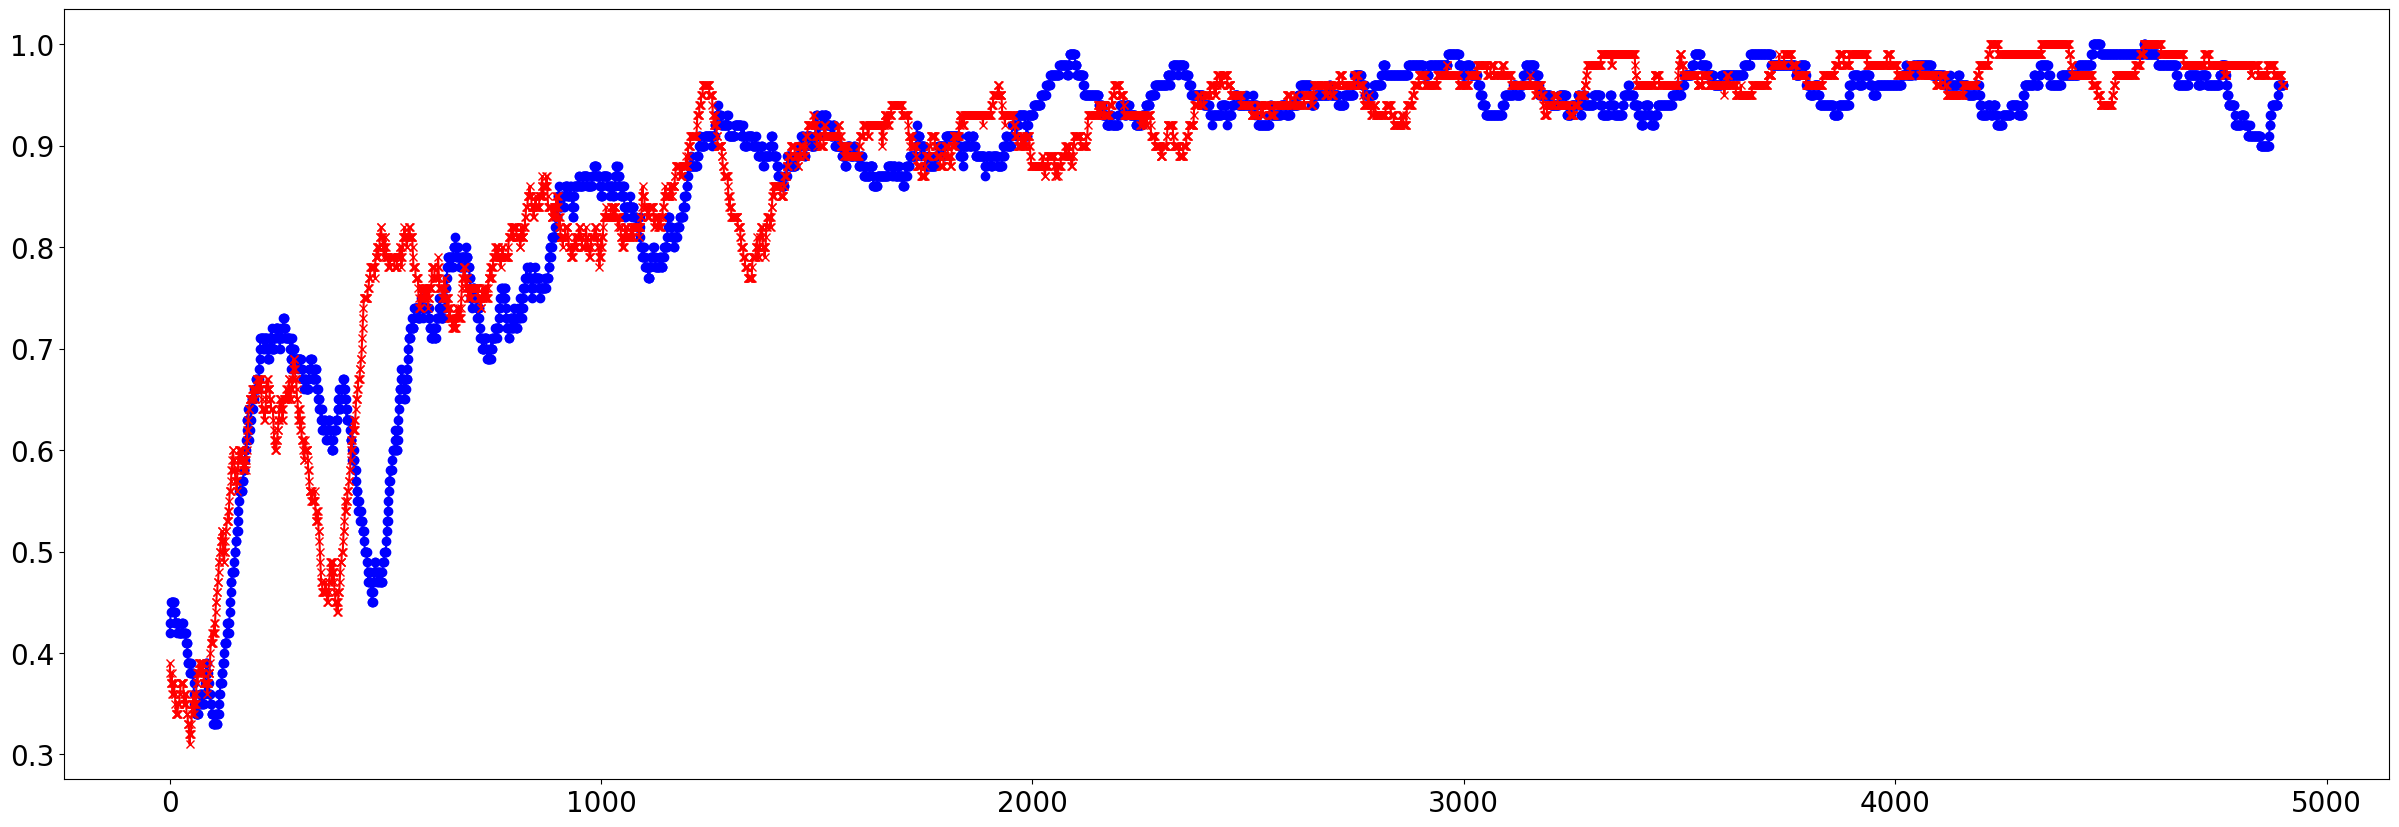

In [7]:
actions = np.array(actions)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.plot(moving_average(actions[:,0],100), label = 'Agent 1 Actions', marker = 'o', c = 'b')
plt.plot(moving_average(actions[:,1],100), label = 'Agent 2 Actions', marker = 'x', c = 'r')